# Test vectorization, rasterization tools

In [1]:
import vectorization_tools, rasterization_tools
from keras.layers import Input
import numpy as np
# from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline

#from config import #DATASET

from utils import load_icse_data, check_label
from predictor import Predictor

img_rows, img_cols = 28, 28
img_chn = 1

2024-07-29 23:32:11.002868: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 23:32:11.074597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 23:32:12.111710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-29 23:32:13.854139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

FMNIST Model1 loaded
Loaded model from disk


In [2]:
EXPLABEL = 0

x_test1, y_test1, image_files1 = load_icse_data(confidence_is_100=False, label=EXPLABEL)
x_test2, y_test2, image_files2 = load_icse_data(confidence_is_100=True, label=EXPLABEL)
x_test = np.concatenate([x_test1, x_test2], axis=0)
y_test = np.concatenate([y_test1, y_test2], axis=0)
image_files = np.concatenate([image_files1, image_files2], axis=0)
x_test, y_test, image_files = check_label(x_test, y_test, image_files, EXPLABEL)

2024-07-29 23:32:16.960238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906
2024-07-29 23:32:17.265185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Dropped 2 images after rasterization


In [3]:
def plot_original_and_rasterized(confidence_100, explabel):
    x_test, y_test, _ = load_icse_data(confidence_100, explabel)

    fig, axs = plt.subplots((len(y_test)+4)//5*2,5)
    fig.tight_layout()
    predict_ori = Predictor.predict(x_test, y_test)
    # print(predict_ori)

    label_presevation_num = 0
    for i, img in enumerate(x_test):
        r = i//5 *2
        c = i-i//5*5
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)

        label_rasterized = Predictor.predict_single(rasterized , explabel)[0]
        if label_rasterized == explabel:
            label_presevation_num += 1
        axs[r, c].imshow(np.reshape(img,(img_rows, img_cols) ))
        axs[r+1, c].imshow(np.reshape(rasterized,(img_rows, img_cols) ))
        axs[r, c].set_title(f"Original {predict_ori[0][i]}, {predict_ori[1][i]}")
        axs[r+1, c].set_title(f"rasterized {Predictor.predict_single(rasterized , explabel)[0]}")

    return label_presevation_num

label preservation rate is 0.93


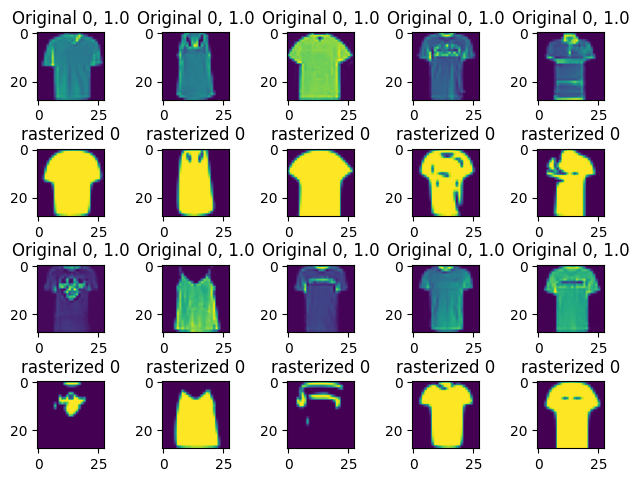

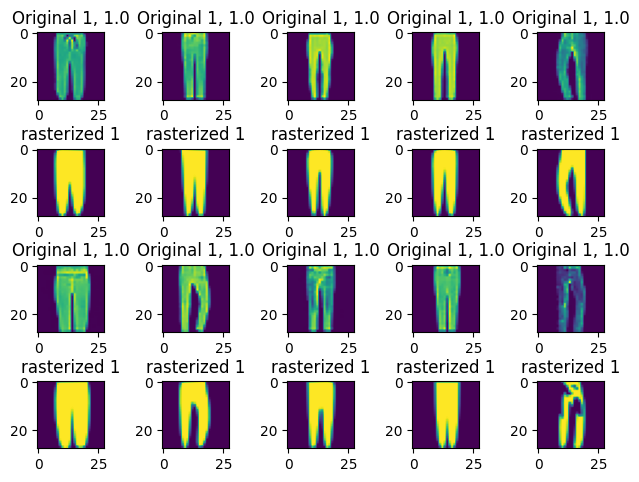

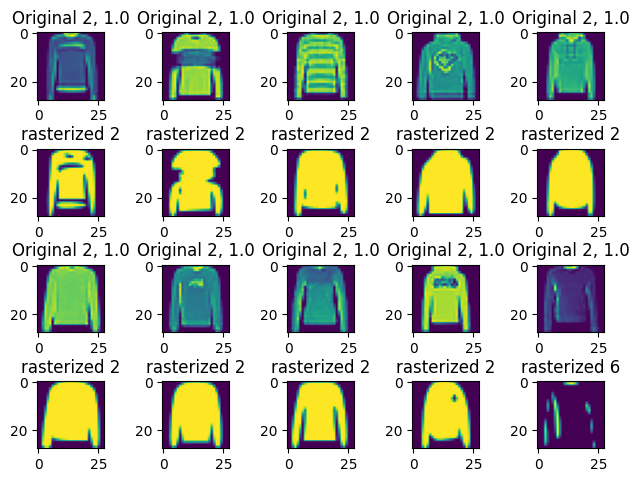

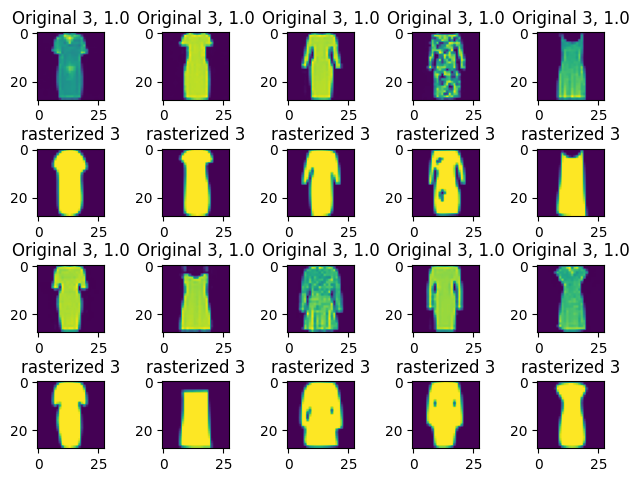

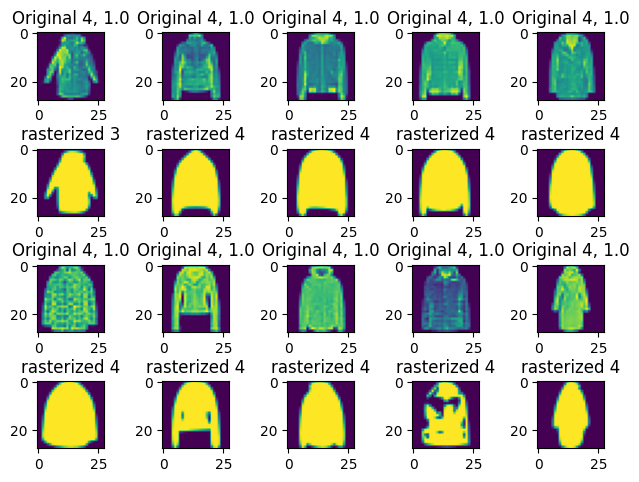

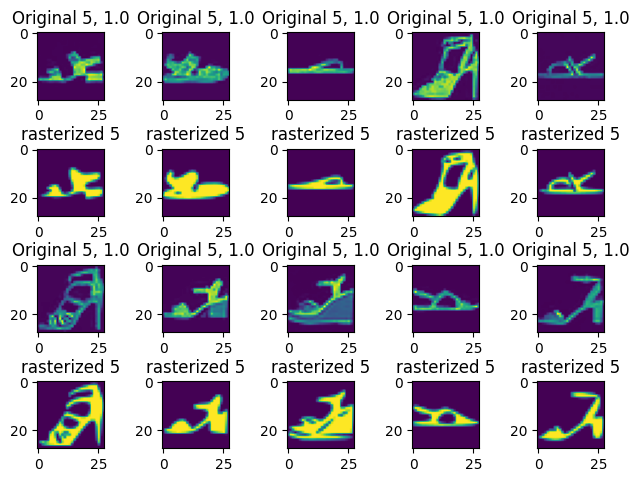

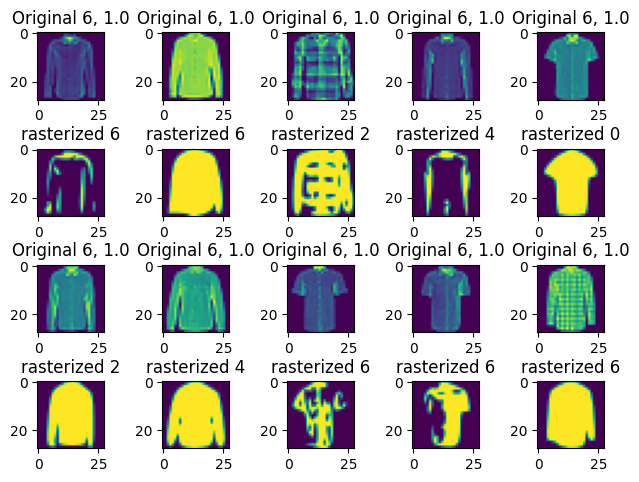

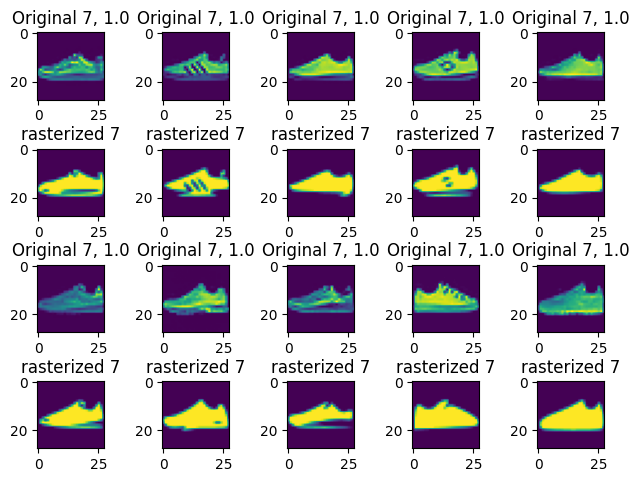

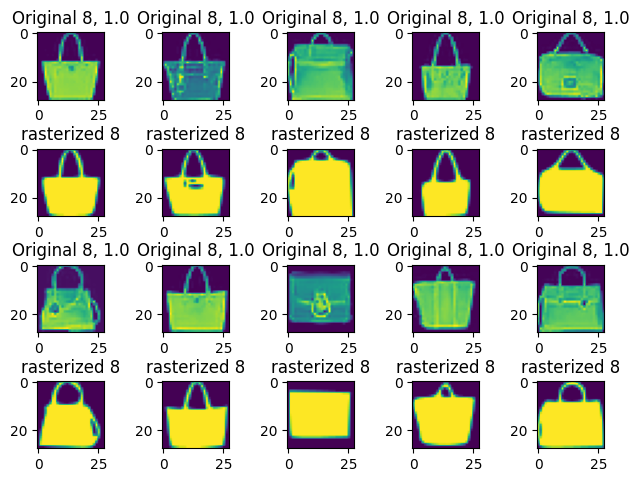

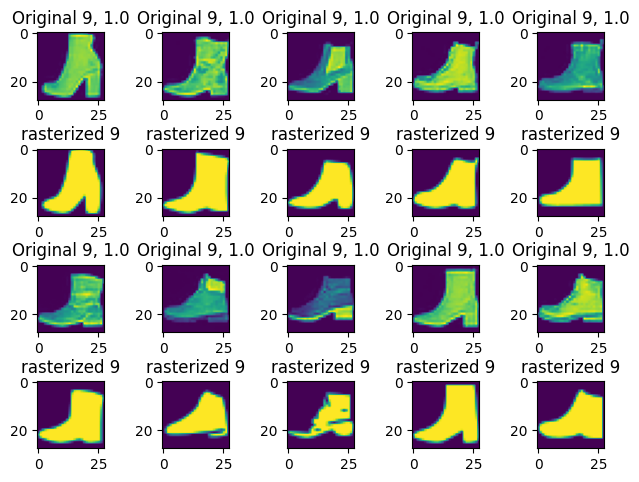

In [4]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized(True, i)

print(f"label preservation rate is {label_presevation_num/100}")

label preservation rate is 0.69


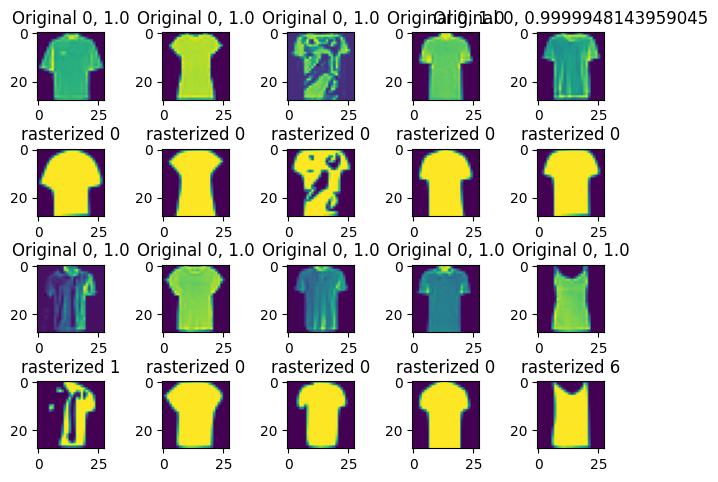

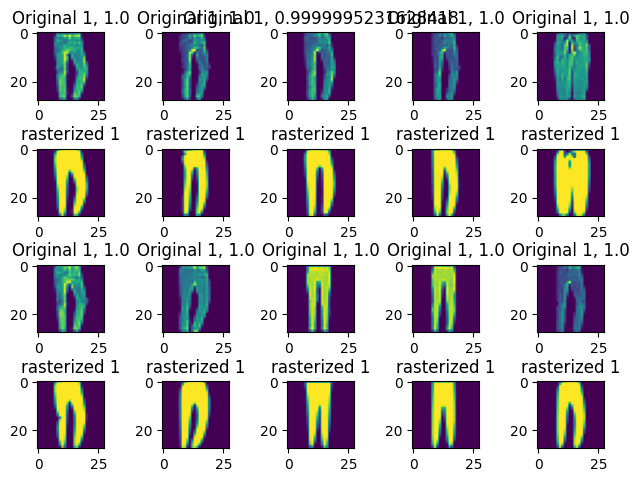

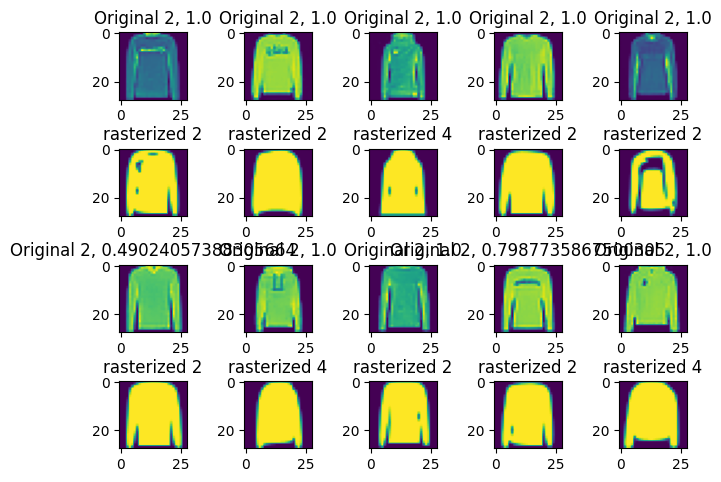

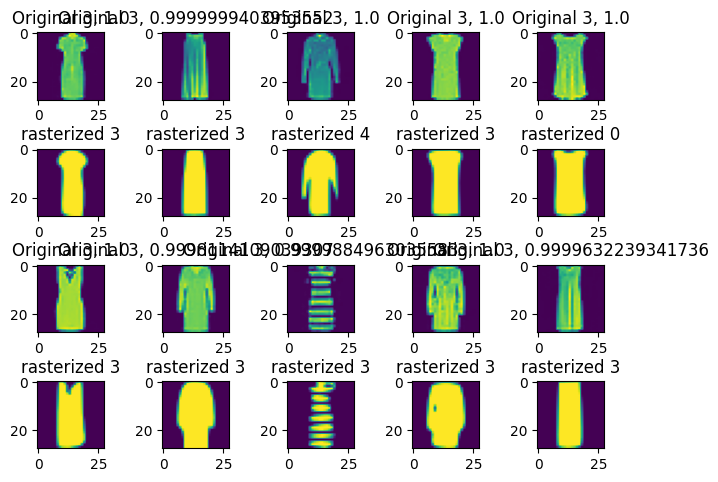

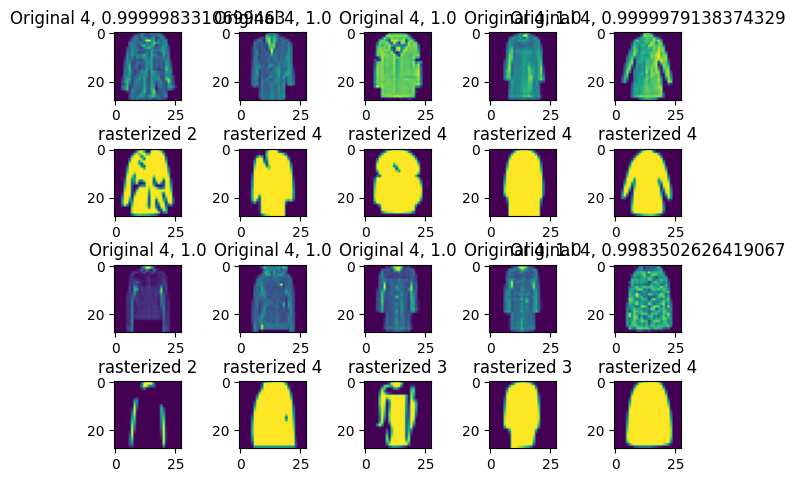

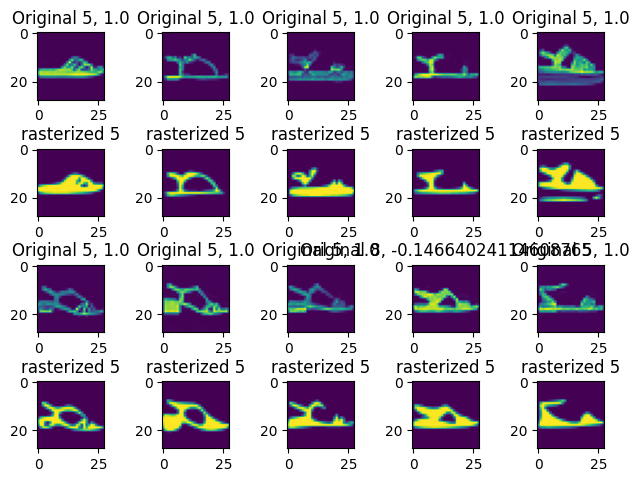

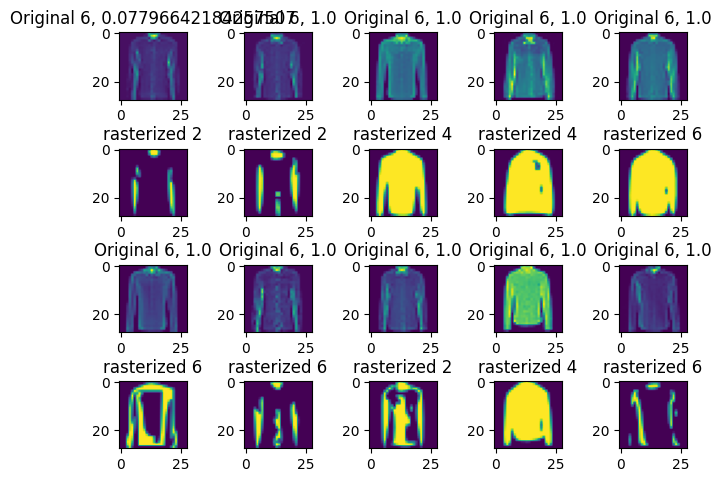

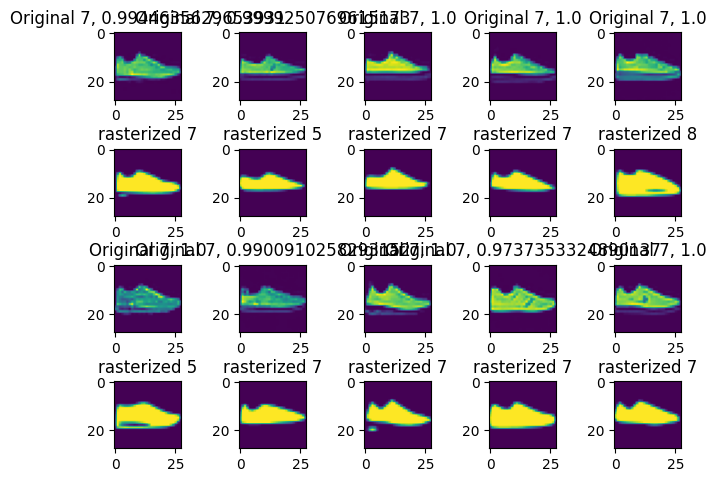

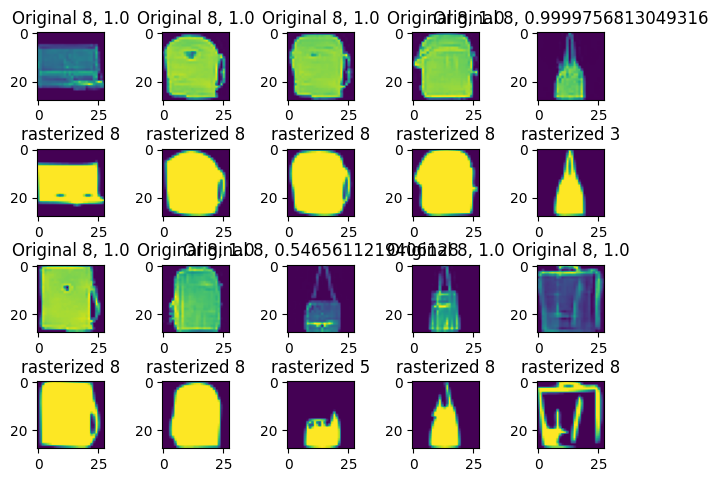

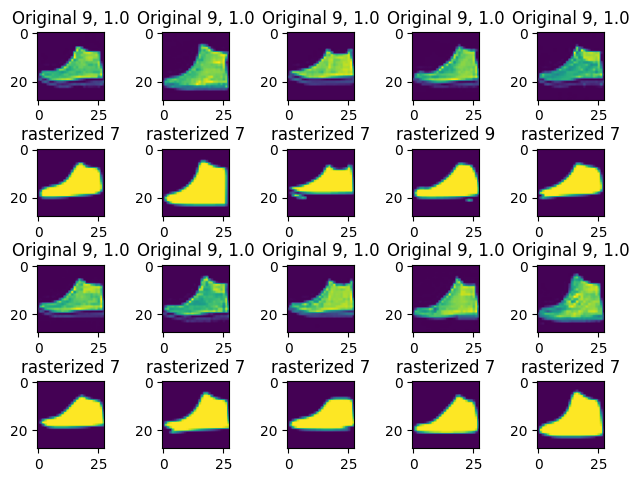

In [5]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized(False, i)

print(f"label preservation rate is {label_presevation_num/100}")

In [6]:
def check_label(x_test, y_test, explabel):
    predictions, _ = (Predictor.predict(img=x_test, label=y_test))
    predictions = np.array(predictions)
    
    # drop labels that are not EXPLABEL
    data_size = x_test.shape[0]
    
    x_test = x_test[predictions == explabel]
    y_test = y_test[predictions == explabel]
    
    if data_size != x_test.shape[0]:
        print("Dropped {} images with wrong label".format(data_size - x_test.shape[0]))
    data_size = x_test.shape[0]
    assert data_size!=0, "No data left"
    
    # drop labels that are not EXPLABEL after rasterization
    new_predictions = []
    for img in x_test:
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)
        prediction_rasterized, _ = Predictor.predict_single(rasterized, explabel)
        new_predictions.append(prediction_rasterized)

    new_predictions = np.array(new_predictions)
    x_test = x_test[np.where(new_predictions == explabel)]
    y_test = y_test[np.where(new_predictions == explabel)]
    if data_size != x_test.shape[0]:
        print("Dropped {} images after rasterization".format(data_size - x_test.shape[0]))
    assert x_test.shape[0]!=0, "No data left"
    
    return x_test, y_test
    

def plot_original_and_rasterized_after_drop(confidence_100, explabel):
    x_test, y_test = load_icse_data(confidence_100, explabel)
    x_test, y_test = check_label(x_test, y_test, explabel)

    if len(y_test) == 0:
        print(f"Nothing left in label {explabel}")
        return 0

    fig, axs = plt.subplots((len(y_test)+4)//5*2,5)
    fig.tight_layout()
    predict_ori = Predictor.predict(x_test, y_test)
    

    label_presevation_num = 0
    for i, img in enumerate(x_test):
        r = i//5 *2
        c = i-i//5*5
        xml_desc = vectorization_tools.vectorize(img)
        rasterized = rasterization_tools.rasterize_in_memory(xml_desc)

        label_rasterized = Predictor.predict_single(rasterized , explabel)[0]
        if label_rasterized == explabel:
            label_presevation_num += 1
        axs[r, c].imshow(np.reshape(img,(img_rows, img_cols) ))
        axs[r+1, c].imshow(np.reshape(rasterized,(img_rows, img_cols) ))
        axs[r, c].set_title(f"Original {predict_ori[0][i]}, {predict_ori[1][i]}")
        axs[r+1, c].set_title(f"rasterized {Predictor.predict_single(rasterized , explabel)[0]}")

    return label_presevation_num

In [7]:
x_test, y_test = load_icse_data(False, 0)
x_test, y_test = check_label(x_test, y_test, explabel)
print(len(y_test))

ValueError: too many values to unpack (expected 2)

In [ ]:
(7+4)//5*2

In [ ]:
label_presevation_num = plot_original_and_rasterized_after_drop(False, 0)

In [ ]:
label_presevation_num = 0
for i in range(10):
    label_presevation_num += plot_original_and_rasterized_after_drop(False, i)

print(f"label preservation rate is {label_presevation_num/100}")